In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import CSVLogger
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from pickle import load

In [2]:
IMAGE_SIZE = [224, 224]
train_path = '../input/final-dataset-28/Mushroom_Classification_28/train'
val_path = '../input/final-dataset-28/Mushroom_Classification_28/val'
test_path = '../input/final-dataset-28/Mushroom_Classification_28/test'

In [ ]:
model = Sequential()

pretrained_model= tf.keras.applications.DenseNet169(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

2022-11-06 05:14:26.491238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:14:26.600389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:14:26.601271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:14:26.603337: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [ ]:
csv_logger = CSVLogger('/kaggle/working/densenet169_results.csv')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale = 1./255)
   
test_datagen = ImageDataGenerator(
    rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle=True)

val_set = val_datagen.flow_from_directory(val_path,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical',
                                          shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 23992 images belonging to 3 classes.
Found 2997 images belonging to 3 classes.
Found 3003 images belonging to 3 classes.


In [ ]:
STEPS_PER_EPOCH = train_set.n//train_set.batch_size
VALIDATION_STEPS = val_set.n//val_set.batch_size

In [ ]:
# fit the model
r = model.fit_generator(
  train_set,
  validation_data=val_set,
  epochs=100,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_steps=VALIDATION_STEPS,
  verbose=1,
  callbacks=[csv_logger])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-06 05:15:15.610483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-06 05:15:25.711312: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


749/749 [==============================] - 504s 652ms/step - loss: 0.8135 - accuracy: 0.6273 - val_loss: 0.6724 - val_accuracy: 0.7087
Epoch 2/100
749/749 [==============================] - 335s 447ms/step - loss: 0.6428 - accuracy: 0.7290 - val_loss: 0.6399 - val_accuracy: 0.7127
Epoch 3/100
749/749 [==============================] - 325s 434ms/step - loss: 0.5438 - accuracy: 0.7780 - val_loss: 0.5238 - val_accuracy: 0.7853
Epoch 4/100
749/749 [==============================] - 330s 440ms/step - loss: 0.4756 - accuracy: 0.8106 - val_loss: 0.4832 - val_accuracy: 0.8112
Epoch 5/100
749/749 [==============================] - 329s 439ms/step - loss: 0.4246 - accuracy: 0.8331 - val_loss: 0.4202 - val_accuracy: 0.8411
Epoch 6/100
749/749 [==============================] - 325s 434ms/step - loss: 0.3801 - accuracy: 0.8514 - val_loss: 0.3883 - val_accuracy: 0.8606
Epoch 7/100
749/749 [==============================] - 324s 432ms/step - loss: 0.3431 - accuracy: 0.8673 - val_loss: 0.3827 - val_

In [ ]:
test_loss, test_acc = model.evaluate(test_set, verbose=1)

3003/3003 [==============================] - 93s 31ms/step - loss: 0.3774 - accuracy: 0.9274


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


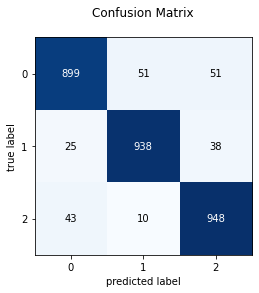

In [10]:
num_of_test_samples = test_set.n
batch_size = test_set.batch_size

Y_pred = model.predict_generator(test_set, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
conf_matrix = confusion_matrix(test_set.classes, y_pred)
cm = np.array2string(conf_matrix)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix)
ax.set_title('Confusion Matrix\n');
plt.show()

In [ ]:
print('Classification Report')
target_names = ['Edible','Inedible','Poisonous']
class_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(class_report)

Classification Report
              precision    recall  f1-score   support

      Edible       0.93      0.90      0.91      1001
    Inedible       0.94      0.94      0.94      1001
   Poisonous       0.91      0.95      0.93      1001

    accuracy                           0.93      3003
   macro avg       0.93      0.93      0.93      3003
weighted avg       0.93      0.93      0.93      3003



In [12]:
print('Log Loss')
l_loss = log_loss(test_set.classes, Y_pred)
print(l_loss)

Log Loss
0.37292692317026177


In [13]:
print('ROC AUC Score')
r_a_score = roc_auc_score(test_set.classes, Y_pred, multi_class='ovr')
print(r_a_score)

ROC AUC Score
0.9870410974307079


In [14]:
model.save('/kaggle/working/DenseNet169.h5')

In [ ]:
DenseNet169 = load_model('/kaggle/working/DenseNet169.h5')

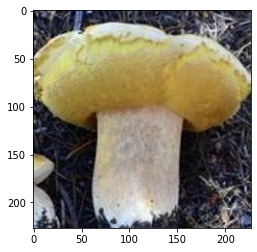

Inedible


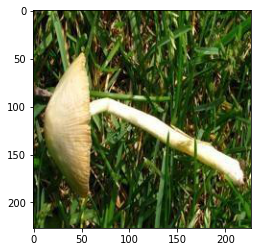

Inedible


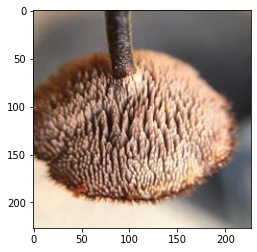

Poisonous


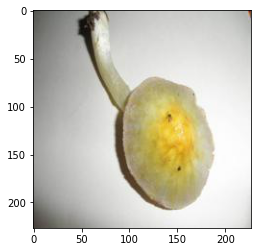

Inedible


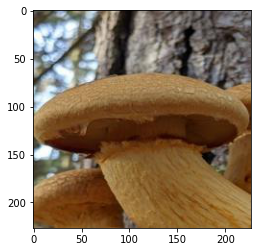

Inedible


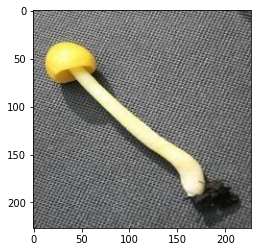

Inedible


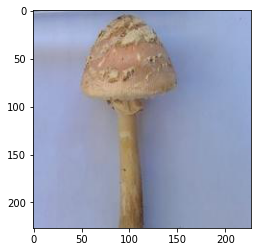

Edible


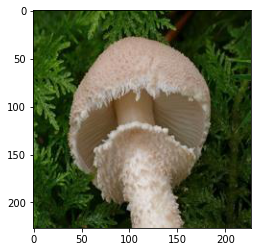

Inedible


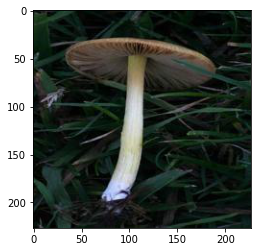

Inedible


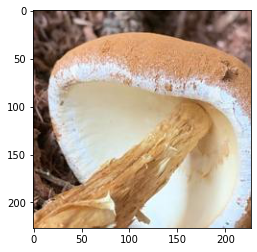

Inedible


In [15]:
from keras.preprocessing import image
import os
from os import listdir

folder_dir = "../input/final-test-data/Test_Data/Inedible"
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        im = plt.imread("../input/final-test-data/Test_Data/Inedible/"+images)
        plt.imshow(im)
        plt.show()
        output=[]
        img = image.load_img(os.path.join("../input/final-test-data/Test_Data/Inedible",images),target_size=(224,224))
        img = np.asarray(img)
        img = np.expand_dims(img, axis=0)
        output = model.predict(img)
    
        if output[0][0] > output[0][1] and output[0][0] > output[0][2]:
            print("Edible")
        elif output[0][1] > output[0][0] and output[0][1] > output[0][2]:
            print('Inedible')
        elif output[0][2] > output[0][0] and output[0][2] > output[0][1]:
            print('Poisonous')